# Introduction

The following tutorial will exemplify the  Active Learning for Regression Using Greedy Sampling from Dongrui Wu, Chin-Teng Lin, Jian Huang.


# Set Up

## Import Packages

In [1]:
### Import Packages ###
import os
import math as math
import pandas as pd
import random as random

### Append Path ###
import sys
sys.path.append('..')

### Local Packages ###
from utils.Prediction import *
from utils.Selector import *
from utils.Auxiliary import *
from utils.Main import *

## Load Data

In [2]:
### Data ###
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)
df = pd.DataFrame(data=boston.data, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
df = df.drop(columns=["CHAS", "RAD"])
df['Y'] = boston.target

## Input Parameters

In [3]:
### Get Directory ###
cwd = os.getcwd()
ParentDirectory = os.path.abspath(os.path.join(cwd, ".."))

### Input ###
SimulationConfigInput = {'Seed': 1,                     # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'GSxFunction',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'RandomForestRegressorFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05,                          # Ignore this for now (used for Rashomon)
    'Type': 'Regression'}                               # Options: [Classification, Regression]

### Set Up ###
StartTime = time.time()
random.seed(SimulationConfigInput["Seed"])
np.random.seed(SimulationConfigInput["Seed"])

### Store Results ###
ErrorVec = []
SelectedObservationHistory = []
TreeCount = {"AllTreeCount": [], "UniqueTreeCount": []}

### Train Test Candidate Split ###
df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, SimulationConfigInput["TestProportion"], SimulationConfigInput["CandidateProportion"])

### Update SimulationConfig Arguments ###
SimulationConfigInput['df_Train'] = df_Train
SimulationConfigInput["df_Test"] = df_Test
SimulationConfigInput["df_Candidate"] = df_Candidate


# For Loop

The following is a loop that identifies parts of the active learning process. Look at each chunk and each section, and then go into the function in the directory.

In [4]:
### Learning Procedure ###
for i in range(len(df_Candidate)):

    ### Prediction Model ###
    print("Iteration: " + str(i))
    ModelType = globals().get(SimulationConfigInput["ModelType"], None)                        # Extracts the right model
    ModelArgsFiltered = FilterArguments(ModelType, SimulationConfigInput)                      # Selects the variables needed for the type of model
    Model = ModelType(**ModelArgsFiltered)                                                     # Inputs the right variables needed for the type of model
    SimulationConfigInput['Model'] = Model                                                     # Updates model

    ### Test Error ###
    TestErrorOutput = TestErrorFunction(InputModel = Model, df_Test = SimulationConfigInput["df_Test"], Type = SimulationConfigInput["Type"])
    if('TREEFARMS' in str(type(Model))):                                                         # If Rashomon
        CurrentError = TestErrorOutput["Error_Duplicate"]
    else: 
        CurrentError = TestErrorOutput["ErrorVal"]                                               # One output for non-Rashomon
    ErrorVec.append(CurrentError)

    ### Sampling Procedure ###
    SelectorType = globals().get(SimulationConfigInput["SelectorType"], None)                      # Extracts the right selector
    SelectorArgsFiltered = FilterArguments(SelectorType, SimulationConfigInput)                    # Selects the variables needed for the type of selector
    SelectorFuncOutput = SelectorType(**SelectorArgsFiltered)                                      # Inputs the right variavles needed for the type of selector
    QueryObservationIndex = SelectorFuncOutput["IndexRecommendation"]                              # Extracts the index of the recommended observation
    QueryObservation = SimulationConfigInput["df_Candidate"].loc[[QueryObservationIndex]]          # Extracts the entire observation using the recommended index
    SelectedObservationHistory.append(QueryObservationIndex)                                       # Appends to the selection history

    ### Update Train and Candidate Sets ###
    SimulationConfigInput["df_Train"] = pd.concat([SimulationConfigInput["df_Train"], QueryObservation])
    SimulationConfigInput["df_Candidate"] = SimulationConfigInput["df_Candidate"].drop(QueryObservationIndex) 

    ### Store Number of (Unique) Trees ###
    if('TREEFARMS' in str(type(Model))):
        TreeCount["AllTreeCount"].append(SelectorFuncOutput["AllTreeCount"])          # Store number of trees
        TreeCount["UniqueTreeCount"].append(SelectorFuncOutput["UniqueTreeCount"])    # Store number of unique/duplicate trees


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

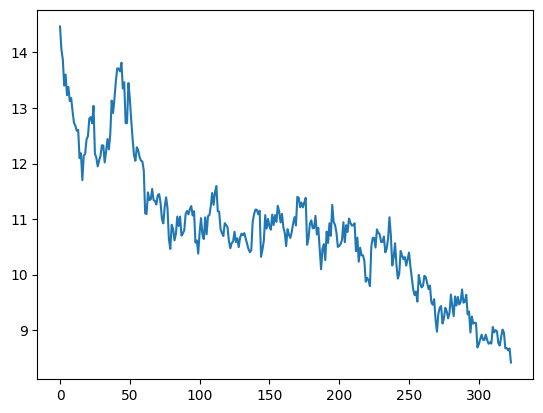

In [6]:
plt.plot(ErrorVec)

# Local Simulation

The function OneIterationFunction will do all all of that above! The for loop was just written out so that you can see what is happenning internally and make the connection to the active learning procedure you've been reading in your papers. 

The only thing you have to change is the parameters in SimulationConfigInput.

## Linear Regression

The following will run the active learning procedure with linear regression as the model. It will run the procedure with four different types of selectors: passive/random querying, GSx, GSy, and iGS.

In [7]:
LinearRegressionActiveLearningResults = {}

### Random/Passive Learning

In [8]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'PassiveLearning',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'LinearRegressionFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
LinearRegressionResults_Passive = OneIterationFunction(SimulationConfigInput)
LinearRegressionActiveLearningResults["Passive"] = LinearRegressionResults_Passive


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Selector: GSx

In [9]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'GSxFunction',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'LinearRegressionFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
LinearRegressionResults_GSx = OneIterationFunction(SimulationConfigInput)
LinearRegressionActiveLearningResults["GSx"] = LinearRegressionResults_GSx

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Selector: GSy

In [10]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'GSyFunction',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'LinearRegressionFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
LinearRegressionResults_GSy = OneIterationFunction(SimulationConfigInput)
LinearRegressionActiveLearningResults["GSy"] = LinearRegressionResults_GSy


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Selector: iGS

In [11]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'iGSFunction',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'LinearRegressionFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
LinearRegressionResults_iGS = OneIterationFunction(SimulationConfigInput)
LinearRegressionActiveLearningResults["iGS"] = LinearRegressionResults_iGS

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Linear Regression Active Learning Results

In [12]:
### Set Up ###
SimulationErrorResults = {"Passive" : LinearRegressionActiveLearningResults["Passive"]["ErrorVec"],
                          "GSx" : LinearRegressionActiveLearningResults["GSx"]["ErrorVec"],
                          "GSy" : LinearRegressionActiveLearningResults["GSy"]["ErrorVec"],
                          "iGS" : LinearRegressionActiveLearningResults["iGS"]["ErrorVec"],}

### Aesthetics ###
# PlotSubtitle = f"Dataset: {SimulationConfigInput["DataFileInput"]}"
PlotSubtitle="BostonHousing with Linear Regression"
Colors = {
    "Passive": "black",
    "GSx": "green",
    "GSy": "orange",
    "iGS": "blue"
}

Linestyles = {
    "Passive": "solid",
    "GSx": "solid",
    "GSy": "solid",
    "iGS": "solid"
}

LegendMapping = {
    "Passive": "Passive",
    "GSx": "GSx",
    "GSy": "GSy",
    "iGS": "iGS"
}


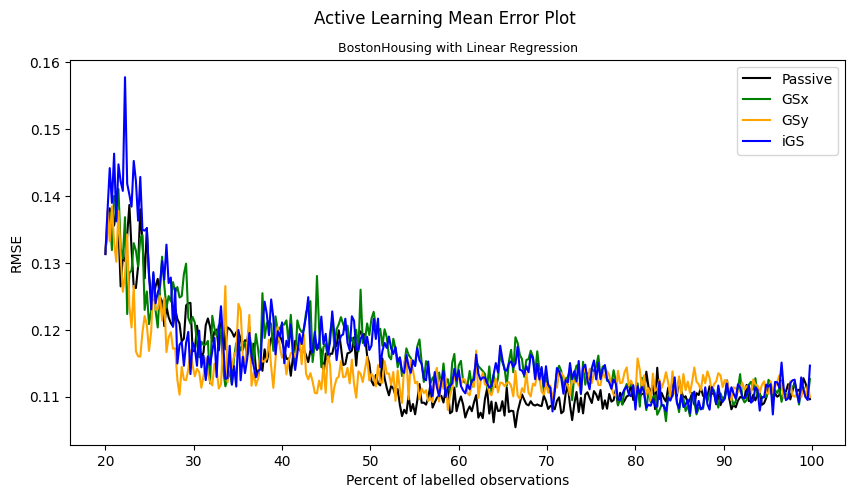

In [13]:
### Mean Plot ###
plt.figure(figsize=[10,5])
for Label, Values in SimulationErrorResults.items():
    x = 20 + (np.arange(len(Values)) / len(Values)) * 80  # Start at 20% and go to 100%
    color = Colors.get(Label, None) if Colors else None 
    linestyle = Linestyles.get(Label, ':') if Linestyles else ':'
    legend_label = LegendMapping[Label] if LegendMapping and Label in LegendMapping else Label
    plt.plot(x, Values, label=legend_label, color=color, linestyle=linestyle)

plt.suptitle("Active Learning Mean Error Plot")
plt.xlabel("Percent of labelled observations")
plt.ylabel("RMSE")
plt.title(PlotSubtitle, fontsize=9)
plt.legend(loc='upper right')
MeanPlot = plt.gcf()

---

## Random Forests

The following will run the active learning procedure with linear regression as the model. It will run the procedure with four different types of selectors: passive/random querying, GSx, GSy, and iGS.

In [14]:
RandomForestsActiveLearningResults = {}

### Random/Passive Learning

In [15]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'PassiveLearning',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'RandomForestRegressorFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
RandomForestsResults_Passive = OneIterationFunction(SimulationConfigInput)
RandomForestsActiveLearningResults["Passive"] = RandomForestsResults_Passive


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Selector: GSx

In [16]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'GSxFunction',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'RandomForestRegressorFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
RandomForestsResults_GSx = OneIterationFunction(SimulationConfigInput)
RandomForestsActiveLearningResults["GSx"] = RandomForestsResults_GSx

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Selector: GSy

In [17]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'GSyFunction',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'RandomForestRegressorFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
RandomForestsResults_GSy = OneIterationFunction(SimulationConfigInput)
RandomForestsActiveLearningResults["GSy"] = RandomForestsResults_GSy


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Selector: iGS

In [18]:
### Input ###
SimulationConfigInput = {
    "DataFileInput" : "BostonHousing",                  # Data File Input
    'Seed': 1,                                          # Seed
    'TestProportion': 0.2,                              # Test proportion
    'CandidateProportion': 0.8,                         # Candidate proportion
    'SelectorType': 'iGSFunction',                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
    'ModelType': 'RandomForestRegressorFunction',       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
    'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
    'Type': 'Regression',                               # Options: [Classification, Regression]
    'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
    'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
    'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
    'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)

### Run Function
RandomForestsResults_iGS = OneIterationFunction(SimulationConfigInput)
RandomForestsActiveLearningResults["iGS"] = RandomForestsResults_iGS

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Random Forest Active Learning Results

In [19]:
### Set Up ###
SimulationErrorResults = {"Passive" : RandomForestsActiveLearningResults["Passive"]["ErrorVec"],
                          "GSx" : RandomForestsActiveLearningResults["GSx"]["ErrorVec"],
                          "GSy" : RandomForestsActiveLearningResults["GSy"]["ErrorVec"],
                          "iGS" : RandomForestsActiveLearningResults["iGS"]["ErrorVec"],}

### Aesthetics ###
# PlotSubtitle = f"Dataset: {SimulationConfigInput["DataFileInput"]}"
PlotSubtitle= "BostonHousing with RandomForests"
Colors = {
    "Passive": "black",
    "GSx": "green",
    "GSy": "orange",
    "iGS": "blue"
}

Linestyles = {
    "Passive": "solid",
    "GSx": "solid",
    "GSy": "solid",
    "iGS": "solid"
}

LegendMapping = {
    "Passive": "Passive",
    "GSx": "GSx",
    "GSy": "GSy",
    "iGS": "iGS"
}


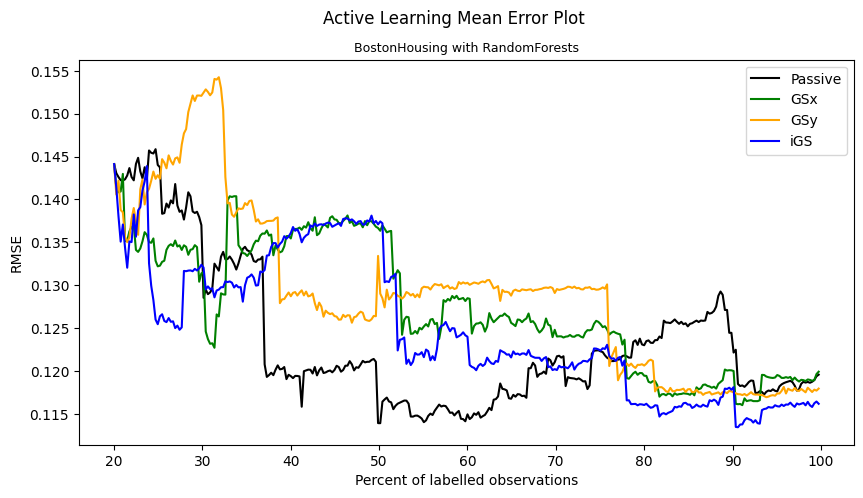

In [20]:
### Mean Plot ###
plt.figure(figsize=[10,5])
for Label, Values in SimulationErrorResults.items():
    x = 20 + (np.arange(len(Values)) / len(Values)) * 80  # Start at 20% and go to 100%
    color = Colors.get(Label, None) if Colors else None 
    linestyle = Linestyles.get(Label, ':') if Linestyles else ':'
    legend_label = LegendMapping[Label] if LegendMapping and Label in LegendMapping else Label
    plt.plot(x, Values, label=legend_label, color=color, linestyle=linestyle)

plt.suptitle("Active Learning Mean Error Plot")
plt.xlabel("Percent of labelled observations")
plt.ylabel("RMSE")
plt.title(PlotSubtitle, fontsize=9)
plt.legend(loc='upper right')
MeanPlot = plt.gcf()

# Tasks

## 1. Multiple Simulations

Ordinarily, in order to compare methods we want a wide range of simulations. In the above work, we only ran 1 simulation. Instead, we want to run 100 simulations each with diferent seeds for each method, average the methods, then compare their results. I will walk you through this. 

1. Firstly, initialize a list for the four selector methods methods (one for each mehod: GSxFunction, GSyFunction, iGSFunction, PassiveLearning) to store your results.
2. Within a for loop between 0 and 99, 
    - Set the seed to the current number of the looop
    - Construct 4 SimulationConfigInput
    - Run the four iteration functions for each method.
        - OneIterationFunction(SimulationConfigInput_Passive)
        - OneIterationFunction(SimulationConfigInput_GSx)
        - OneIterationFunction(SimulationConfigInput_GSy)
        - OneIterationFunction(SimulationConfigInput_iGS)
    - Append each of the four methods to their respective results.
3. Average the error results within the four methods.
4. Create an active learning plot showing the time by number of labelled observations.
5. Report the average run time of each selector method.

Note this will take **a very long time!** I suspect each loop to take 2 minutes. You are essentially running 4 active learning processes 100 times (with each active learning process takeung about 30 seconds). I would recommend letting this run overnight. Next week, I will show you how can you run this on the university High-Performance Computing Cluster.


## 2. How to change things

To add your own selector techinque or model technique, go to the respective directory (~/utils.Prediction for prediction models or ~/utils.Selector for the selection method) and add your own function! Then in SimulationConfigInput, change the SelectorType or ModelType input to the names of your functions. Try adding a new function (for instance, maybe a support vector machine) to the methods section and try running it!

Additionally, you (Troy) had good ideas for a new selector method. Try to see if you can implement it. Make sure the output is the same as the models/selector methods listed there.

Run the code below to see if it's working, and compare the results to what we've had.

In [ ]:
# YourNewFunctionName = ""
# YourNewSelectorName = ""

# SimulationConfigInput = {
#     "DataFileInput" : "BostonHousing",                  # Data File Input
#     'Seed': 1,                                          # Seed
#     'TestProportion': 0.2,                              # Test proportion
#     'CandidateProportion': 0.8,                         # Candidate proportion
#     'SelectorType': YourNewFunctionName,                      # Options: [GSxFunction, GSyFunction, iGSFunction, PassiveLearning] (all of these are for regression)
#     'ModelType': YourNewSelectorName,       # Options: [LinearRegressionFunction, RandomForestRegressorFunction] (all of these are for regression)
#     'n_estimators': 100,                                # If using RandomForestRegressorFunction/RandomForestClassificationFunction, this is the number of trees
#     'Type': 'Regression',                               # Options: [Classification, Regression]
#     'UniqueErrorsInput': 0,                             # Ignore this for now (used for Rashomon)
#     'regularization': 0.01,                             # Ignore this for now (used for Rashomon)
#     'RashomonThresholdType': "Adder",                   # Ignore this for now (used for Rashomon)
#     'RashomonThreshold': 0.05}                          # Ignore this for now (used for Rashomon)
